# AIM

- To ensure a preprocessing pipeline in one go

Created on: 9 April 2022


# Workspace


In [1]:
##### MODULES
import os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib.dates
import matplotlib.patches
import datetime as dt
import feather
import time

## custom modules
# import sys  
# sys.path.append('../../scripts')

import import_data
import clean_data
import helper
import report
import plotting

##### OPTIONS
pd.options.mode.chained_assignment = None

# autoreload external modules after saving changes to disk
%reload_ext autoreload
%autoreload 2

##### DIRECTORIES
proj_dir = Path('.') / '..' / '..'
source_data_dir = proj_dir/'data'/'source'
clean_data_dir =  proj_dir/'data'/'clean'
viz_dir = proj_dir/'viz'/'preprocessApr09'

In [2]:
preprocess_start = time.time()

# PARAMETERS


In [3]:
WRITE_TO_DISK = True # write artefacts to disk?
OUTPUT_DIR = clean_data_dir / "preprocessApr09"

SAMPLE_PERCENT = 100

SLEEP_TIME_START = '20:00'
SLEEP_TIME_END = '10:00' 
HOURS_ORDERED = [20,21,22,23,0,1,2,3,4,5,6,7,8,9]
# include start boundary only
#todo: generate HOURS from start+end sleep times

DEBUG_HOURS = False

PANDEMIC_CUTOFF   = dt.date(2020, 1, 30) 

## SUBSETTING
SUBSET_START_DATE = None
SUBSET_END_DATE   = None
SUBSET_PID        = None

# Import


In [4]:
phqs_raw, slps_raw, metadata = import_data.import_data(source_data_dir)

# Preprocessing using method 2 (expanding intervals to timestamps)


### 1. Create output directory


In [5]:
OUTPUT_DIR.mkdir(exist_ok=True)

### 2. Clean_slps


In [6]:
with helper.Timer("clean_slps"):
    intervals_all = clean_data.clean_slps(slps_raw)

# [clean_slps]
Elapsed: 2.4 seconds


### 3. Drop intervals after COVID


In [7]:
intervals_all_cleaned = plotting.subset_intervals(intervals_all, end_date=PANDEMIC_CUTOFF, msg="Drop intervals after pandemic")

# Drop intervals after pandemic
1855957->1844095 rows (Change = -11862) (nrow after = 99.36% of before)


In [8]:
#### Subset by criteria

# intervals = plotting.subset_intervals(intervals_all, start_date=SUBSET_START_DATE, end_date=SUBSET_END_DATE, id=SUBSET_PID, msg="Sample a small testing set")

#### ALTERNATIVELY,
#### SLICE THE FIRST FEW PERCENT
if SAMPLE_PERCENT:
    keep_flag = int(np.floor(intervals_all_cleaned.shape[0] * SAMPLE_PERCENT*100))
    intervals = intervals_all_cleaned.head(keep_flag)
else:
    intervals = intervals_all_cleaned.copy()

In [9]:
print(f"Intervals sampled: {intervals.shape[0]}")

Intervals sampled: 1844095


In [10]:
intervals.head(2)

,centre,pid,time,stages,duration,start,start_date,end,intervalID
index,,,,,,,,,
0,ciber,bf3defd7-2a52-4557-8202-9d887957e109,2019-01-21T22:54:00.000,AWAKE,870.0,2019-01-21 22:54:00,2019-01-21,2019-01-21 23:08:00,0
1,ciber,bf3defd7-2a52-4557-8202-9d887957e109,2019-01-21T23:08:30.000,LIGHT,1050.0,2019-01-21 23:08:30,2019-01-21,2019-01-21 23:25:30,1


### 4. Explode


In [11]:
with helper.Timer("explode2ts"):
    timeseries = clean_data.explode2ts(intervals)
    report.report_change_in_nrow(intervals, timeseries)

# [explode2ts]
1844095->73679755 rows (Change = 71835660) (nrow after = 3995.44% of before)
Elapsed: 1060.4 seconds


### 5. Subset timestamps within a defined interval


In [12]:
with helper.Timer("Subset timestamps within defined interval"):
    #todo: optimally,
    timeseries_subset = clean_data.subset_timeseries_within_interval(timeseries, SLEEP_TIME_START, SLEEP_TIME_END, inclusive='left')

# [Subset timestamps within defined interval]
73679755->70601880 rows (Change = -3077875) (nrow after = 95.82% of before)
Elapsed: 8.9 seconds


### !!! Debug

In [13]:
if DEBUG_HOURS:
    mytimes = timeseries_subset['t'].dt.time
    h = [clean_data.time2seconds(t)/3600 for t in mytimes]
    pd.Series(h).plot.hist(bins=24);

### Fix overlap


In [14]:
with helper.Timer("Remove overlapped timestamps and sleep stage labels"):
    dedupped = clean_data.dedup_timeseries(timeseries_subset)

# [Remove overlapped timestamps and sleep stage labels]
70601880->70361127 rows (Change = -240753) (nrow after = 99.66% of before)
Elapsed: 117.0 seconds


### Binning and normalization


In [15]:
with helper.Timer("Binning and normalization"):
    binned = clean_data.bin_by_time(dedupped, freq='1H')
    #! changing the frequency is problematic
    #! because it breaks the 'Expanding to full range of hours' step
    binned_norm = clean_data.normalize_binned(binned)

# [Binning and normalization]
70361127->655535 rows (Change = -69705592) (nrow after = 0.93% of before)
Elapsed: 93.1 seconds


### Expanding to full range of hours


In [16]:
with helper.Timer("Expand to full range of hours"):
    expanded = clean_data.expand_full_hours(binned_norm,hours=HOURS_ORDERED)

# [Expand to full range of hours]
655535->1121806 rows (Change = 466271) (nrow after = 171.13% of before)
Elapsed: 2.7 seconds


### Save


In [18]:
if WRITE_TO_DISK:

    p = OUTPUT_DIR / 'timeseries.ftr'
    timeseries.reset_index(drop=True).to_feather(p)
    
    p = OUTPUT_DIR / 'dedupped.ftr'
    dedupped.reset_index(drop=True).to_feather(p)

    p = OUTPUT_DIR / 'binned.ftr'
    binned.reset_index(drop=True).to_feather(p)
    
    p = OUTPUT_DIR / 'expanded.ftr'
    expanded.reset_index(drop=True).to_feather(p)

    print(OUTPUT_DIR)


### Try other frequencies

Section is unfinished because expand_full_hours is not compatiable with other frequencies.

This is a loop to loop for any frequencies, to be passed into `bin_by_time`, for later use


In [19]:
#### NOT RUN ###
if False:
    ### load from disk
    p = OUTPUT_DIR / 'dedupped.ftr'
    dedupped_all = pd.read_feather(p)

    ### sample
    dedupped = dedupped_all.head(10000)

    ### params
    freqs = ['30M']
    WRITE_TO_TASK = False
        
    ### main loop
    for freq in freqs:
        print(f"### {freq=}")
        
        with helper.Timer("Binning and normalization"):
            binned = clean_data.bin_by_time(dedupped, freq=freq)
            binned_norm = clean_data.normalize_binned(binned)

        with helper.Timer("Expand to full range of hours"):
            binned_norm['hour'] = binned_norm['t'].dt.hour
            binned_norm['start_date'] = binned_norm['t'].dt.date
            expanded = clean_data.expand_full_hours(binned_norm)
            expanded.drop("t", axis=1, inplace=True)

        WRITE_TO_DISK = True
        if WRITE_TO_DISK:
            sufffix = 'preprocess' + freq
            OUTPUT_DIR = proj_dir/'data'/'clean'
            OUTPUT_DIR.mkdir(exist_ok=True)
            
            p = OUTPUT_DIR / 'expanded.ftr'
            expanded.reset_index(drop=True).to_feather(p)

### Import from saves


In [20]:
if False:
    p = OUTPUT_DIR / 'binned.ftr'
    binned = pd.read_feather(p)

    p = OUTPUT_DIR / 'expanded.ftr'
    expanded = pd.read_feather(p)

    p = OUTPUT_DIR / 'dedupped.ftr'
    dedupped = pd.read_feather(p)

# QC histograms by hour


In [21]:
if False:
    import seaborn as sns

    g = sns.FacetGrid(binned, col="hour", height=2.5, col_wrap=6)
    g.map(sns.histplot, "sum");
    plt.savefig(viz_dir/"binned_hist_by_hour.png")

    g = sns.FacetGrid(expanded, col="hour", height=2.5, col_wrap=6)
    g.map(sns.histplot, "sum");
    plt.savefig(viz_dir/"binned_expanded_hist_by_hour.png")

    fig = expanded['sum'].plot.hist(bins=100);

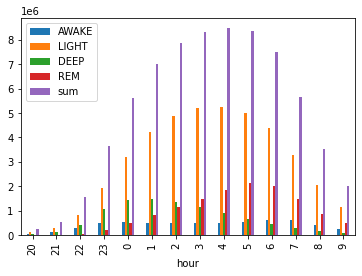

In [22]:
hourly_sums = binned.groupby('hour').sum()
hourly_sums = hourly_sums.reindex(HOURS_ORDERED)
hourly_sums.plot.bar();
plt.savefig(viz_dir/"sleep_stage_duration_by_hour.png")

# Merge (Haotian's code into routine)
using `merge_slp_phq` routine in `clean_data`

In [23]:
with helper.Timer("merge"):
    data_merge2 = clean_data.merge_slp_phq(expanded, phqs_raw)

# [merge]
# Drop PHQ test results which are within 14 days from previous result
4283->4074 rows (Change = -209) (nrow after = 95.12% of before)
# Drop irrelevant rows from outer join
14737226->686560 rows (Change = -14050666) (nrow after = 4.66% of before)
Elapsed: 14.5 seconds


In [24]:
path = OUTPUT_DIR / 'data_merge2.ftr'
data_merge2.reset_index(drop=True).to_feather(path)

In [36]:
helper.beeps()

preprocess_end = time.time()
preprocess_time = preprocess_end - preprocess_start
print(preprocess_time)

# Merge (Haotian's code)

Clean `phqs_raw` to match Haotian's code

In [ ]:
target = phqs_raw[['centre', 'pid', 'time', 'phq']].copy()
target.columns = ['centre', 'id', 'time_y', 'phq']

target['time_y'] = pd.to_datetime(target['time_y'])

Beginning of Haotian's code, with modificdations

In [ ]:
#Clean target data
"""target["test_date"] = target["time_y"].map(lambda x: x[:10])"""
#! replaced by:
target["test_date"] = target['time_y'].dt.date
target_new = target.loc[:,["id", "test_date", "phq"]]

#Get observation start and end times
"""
id_obs_start = data_tab.groupby('id')['date'].min()
id_obs_end = data_tab.groupby('id')['date'].max()
"""

#! replaced by
expanded.columns = ['id', 'date', 'start_time', 'AWAKE', 'DEEP', 'LIGHT', 'REM', 'total']
id_obs_start = expanded.groupby('id')['date'].min()
id_obs_end = expanded.groupby('id')['date'].max()

In [ ]:
#Adjust the time format
target_new["obs_start"] = pd.to_datetime(target_new.test_date) - pd.Timedelta(days=15)

target_new["obs_start"] = target_new["obs_start"].apply(lambda x:x.strftime('%Y-%m-%d'))

In [ ]:
target_new.head(3)

In [ ]:
#Join the tables
target_new = target_new.merge(id_obs_start, on="id", how="left").merge(id_obs_end, on="id", how="left")

#Filter the target data during the observation period
target_select = target_new.loc[
    (pd.to_datetime(target_new['test_date']) >= pd.to_datetime(target_new['date_x'])) & 
    (pd.to_datetime(target_new['obs_start']) <= pd.to_datetime(target_new['date_y']))
]
#Drop extra columns
target_select = target_select.drop(["date_x", "date_y"], axis = 1)


In [ ]:
target_select = clean_data.drop_days_delta(target_select)

In [ ]:
#Link target data and observation data
"""data_merge = pd.merge(target_select, data_tab, how='outer', on=['id'])"""
#! replaced by
data_merge = pd.merge(target_select, expanded, how='outer', on=['id'])

In [ ]:
data_merge.head(3)

In [ ]:
"""
data_merge_select = data_merge.loc[(pd.to_datetime(data_merge.obs_start) <= pd.to_datetime(data_merge.date)) & (pd.to_datetime(data_merge.date) <= pd.to_datetime(data_merge.test_date))]
"""

#! replaced by (formatting)
mask1 = (pd.to_datetime(data_merge.obs_start) <= pd.to_datetime(data_merge.date))
mask2 = (pd.to_datetime(data_merge.date) <= pd.to_datetime(data_merge.test_date))
data_merge_select = data_merge.loc[mask1 & mask2]
report.report_change_in_nrow(data_merge, data_merge_select)

In [ ]:
# Set new ID: old_ID + PHQ time
#! updated
data_merge_select["id_new"] = data_merge_select.id + "_" + data_merge_select.test_date.astype("string")

In [ ]:
# Set new time: date + start_time
#! updated
data_merge_select["time"] = data_merge_select.date.astype("string") + " " + data_merge_select.start_time.astype("string")